# Environment

In [42]:
%%capture
# !git clone https://github.com/cuongtv312/marl-delivery.git marl_delivery

In [2]:
try:
    from marl_delivery.env import Environment
except:
    from env import Environment
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
import random
import os
from sklearn.calibration import LabelEncoder



SEED = 42
device = torch.device("cuda:22" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
device

device(type='cuda', index=22)

In [3]:
def convert_observation(state, persistent_packages, current_robot_idx):
    """
    Convert state to a 2D multi-channel tensor for a specific robot.
    - 6 channels for robot-specific observation:
        0. Map
        1. Urgency of 'waiting' packages (if robot is not carrying)
        2. Start positions of 'waiting' packages (if robot is not carrying)
        3. Other robots' positions
        4. Current robot's position
        5. Current robot's carried package target (if robot is carrying)

    Args:
        state (dict): Raw state from the environment.
                      Expected keys: "map", "robots", "time_step".
                      state["robots"] is a list of tuples: (pos_x+1, pos_y+1, carrying_package_id)
        persistent_packages (dict): Dictionary tracking all active packages.
                                    Positions are 0-indexed.
        current_robot_idx (int): Index of the current robot for which to generate the observation.

    Returns:
        np.ndarray of shape (6, n_rows, n_cols)
    """
    grid = np.array(state["map"])
    n_rows, n_cols = grid.shape
    n_channels = 6
    tensor = np.zeros((n_channels, n_rows, n_cols), dtype=np.float32)

    # --- Channel 0: Map ---
    tensor[0] = grid

    current_time_step = state["time_step"]
    if isinstance(current_time_step, np.ndarray): # Handle case where time_step might be an array
        current_time_step = current_time_step[0]

    # Get current robot's data and determine if it's carrying a package
    # Ensure current_robot_idx is valid
    if current_robot_idx < 0 or current_robot_idx >= len(state["robots"]):
        # This case should ideally be handled by the caller or indicate an error
        # print(f"Warning: Invalid current_robot_idx {current_robot_idx}")
        return tensor # Return empty tensor or handle error appropriately

    current_robot_data = state["robots"][current_robot_idx]
    carried_pkg_id_by_current_robot = current_robot_data[2] # 1-indexed ID, 0 if not carrying

    # --- Channel 1: Urgency of 'waiting' packages (if robot is not carrying) ---
    # --- Channel 2: Start positions of 'waiting' packages (if robot is not carrying) ---
    if carried_pkg_id_by_current_robot == 0: # Robot is NOT carrying a package
        for pkg_id, pkg_data in persistent_packages.items():
            if pkg_data['status'] == 'waiting':
                sr, sc = pkg_data['start_pos']  # 0-indexed
                st = pkg_data['start_time']
                dl = pkg_data['deadline']

                # Check if package is active (start_time has passed)
                if current_time_step >= st:
                    # Channel 1: Urgency
                    urgency = 0
                    if dl > st: # Avoid division by zero or negative duration
                        # Normalize urgency: 0 (just appeared) to 1 (deadline reached)
                        # Cap at 1 if current_time_step exceeds deadline
                        urgency = min(1.0, max(0.0, (current_time_step - st) / (dl - st)))
                    elif dl == st: # Deadline is the start time
                         urgency = 1.0 if current_time_step >= st else 0.0
                    # else: dl < st, invalid, urgency remains 0

                    if 0 <= sr < n_rows and 0 <= sc < n_cols: # Boundary check
                        tensor[1, sr, sc] = max(tensor[1, sr, sc], urgency) # Use max if multiple pkgs at same spot

                    # Channel 2: Start position
                    if 0 <= sr < n_rows and 0 <= sc < n_cols: # Boundary check
                        tensor[2, sr, sc] = 1.0 # Mark presence
    # If robot is carrying, channels 1 and 2 remain all zeros.

    # --- Channel 3: Other robots' positions ---
    for i, rob_data in enumerate(state["robots"]):
        if i == current_robot_idx:
            continue # Skip the current robot
        rr, rc, _ = rob_data # Positions are 1-indexed from env
        rr_idx, rc_idx = int(rr) - 1, int(rc) - 1 # Convert to 0-indexed
        if 0 <= rr_idx < n_rows and 0 <= rc_idx < n_cols: # Boundary check
            tensor[3, rr_idx, rc_idx] = 1.0

    # --- Channel 4: Current robot's position ---
    # current_robot_data was fetched earlier
    crr, crc, _ = current_robot_data # Positions are 1-indexed
    crr_idx, crc_idx = int(crr) - 1, int(crc) - 1 # Convert to 0-indexed
    if 0 <= crr_idx < n_rows and 0 <= crc_idx < n_cols: # Boundary check
        tensor[4, crr_idx, crc_idx] = 1.0

    # --- Channel 5: Current robot's carried package target (if robot is carrying) ---
    if carried_pkg_id_by_current_robot != 0:
        # Ensure the package ID from state['robots'] is valid and exists in persistent_packages
        if carried_pkg_id_by_current_robot in persistent_packages:
            pkg_data_carried = persistent_packages[carried_pkg_id_by_current_robot]
            # Double check status, though if robot carries it, it should be 'in_transit'
            # or just became 'in_transit' in the persistent_packages update logic.
            # For this observation, we primarily care about its target.
            tr_carried, tc_carried = pkg_data_carried['target_pos'] # 0-indexed
            if 0 <= tr_carried < n_rows and 0 <= tc_carried < n_cols: # Boundary check
                tensor[5, tr_carried, tc_carried] = 1.0
        # else:
            # This case might indicate an inconsistency.
            # print(f"Warning: Robot {current_robot_idx} carrying pkg {carried_pkg_id_by_current_robot} not in persistent_packages.")
    # If robot is not carrying, channel 5 remains all zeros.

    return tensor

In [4]:
def convert_state(state_dict, persistent_packages, state_tensor_shape):
    """
    Converts the global state dictionary to a tensor for QMIX.
    Relies on `persistent_packages` for all package information.
    The `packages` key in `state_dict` (if present) is ignored for package data.

    Args:
        state_dict (dict): The raw environment state dictionary.
                           Expected keys: "map", "robots", "time_step".
        persistent_packages (dict): Dictionary tracking all active packages.
                                    Positions are 0-indexed.
                                    Example entry:
                                    { pkg_id: {'start_pos': (r,c), 'target_pos': (r,c),
                                                'status': 'waiting'/'in_transit',
                                                'start_time': ts, 'deadline': dl, 'id': pkg_id} }
        state_tensor_shape (tuple): Tuple (num_channels, n_rows, n_cols) for the output state tensor.
        max_time_steps (int): Maximum time steps in an episode for normalization.

    Returns:
        np.ndarray: The global state tensor with shape specified by state_tensor_shape.
        float: Normalized current time step (scalar feature).
    """
    num_channels_out, n_rows, n_cols = state_tensor_shape
    
    spatial_tensor = np.zeros((num_channels_out, n_rows, n_cols), dtype=np.float32)

    CH_IDX_MAP_OBSTACLES = 0
    CH_IDX_ROBOT_POSITIONS = 1
    CH_IDX_ROBOT_CARRYING_STATUS = 2
    CH_IDX_PKG_WAITING_START_POS = 3
    CH_IDX_PKG_WAITING_TARGET_POS = 4
    CH_IDX_PKG_IN_TRANSIT_TARGET_POS = 5
    CH_IDX_PKG_WAITING_URGENCY = 6

    # --- Channel: Map Obstacles (Centering/Cropping Logic) ---
    if CH_IDX_MAP_OBSTACLES < num_channels_out:
        game_map_from_state = np.array(state_dict["map"])
        map_rows_src, map_cols_src = game_map_from_state.shape

        src_r_start = (map_rows_src - n_rows) // 2 if map_rows_src > n_rows else 0
        src_c_start = (map_cols_src - n_cols) // 2 if map_cols_src > n_cols else 0
        
        rows_to_copy_from_src = min(map_rows_src, n_rows)
        cols_to_copy_from_src = min(map_cols_src, n_cols)

        map_section_to_copy = game_map_from_state[
            src_r_start : src_r_start + rows_to_copy_from_src,
            src_c_start : src_c_start + cols_to_copy_from_src
        ]
        
        target_r_offset = (n_rows - map_section_to_copy.shape[0]) // 2
        target_c_offset = (n_cols - map_section_to_copy.shape[1]) // 2
            
        spatial_tensor[
            CH_IDX_MAP_OBSTACLES,
            target_r_offset : target_r_offset + map_section_to_copy.shape[0],
            target_c_offset : target_c_offset + map_section_to_copy.shape[1]
        ] = map_section_to_copy

    # --- Current Time (Scalar Feature) ---
    current_time = state_dict["time_step"]

    # --- Channels: Robot Positions and Carrying Status (from state_dict['robots']) ---
    if 'robots' in state_dict and state_dict['robots'] is not None:
        for r_data in state_dict['robots']:
            # r_data: (pos_r_1idx, pos_c_1idx, carrying_package_id)
            r_idx, c_idx = int(r_data[0]) - 1, int(r_data[1]) - 1 # Convert to 0-indexed
            carried_pkg_id = r_data[2]

            if 0 <= r_idx < n_rows and 0 <= c_idx < n_cols: # Boundary check
                if CH_IDX_ROBOT_POSITIONS < num_channels_out:
                    spatial_tensor[CH_IDX_ROBOT_POSITIONS, r_idx, c_idx] = 1.0
                
                if carried_pkg_id != 0 and CH_IDX_ROBOT_CARRYING_STATUS < num_channels_out:
                    spatial_tensor[CH_IDX_ROBOT_CARRYING_STATUS, r_idx, c_idx] = 1.0

    # --- Process persistent_packages for ALL package-related channels ---
    # Note: state_dict['packages'] is NOT used here.
    for pkg_id, pkg_data in persistent_packages.items():
        start_pos = pkg_data['start_pos']   # Expected (r, c) 0-indexed
        target_pos = pkg_data['target_pos'] # Expected (r, c) 0-indexed
        status = pkg_data['status']
        pkg_start_time = pkg_data['start_time']
        pkg_deadline = pkg_data['deadline']
        
        # Process only if package is active based on its start_time
        if current_time >= pkg_start_time:
            if status == 'waiting':
                # Channel: Waiting Packages' Start Positions
                if CH_IDX_PKG_WAITING_START_POS < num_channels_out:
                    if 0 <= start_pos[0] < n_rows and 0 <= start_pos[1] < n_cols: # Boundary check
                        spatial_tensor[CH_IDX_PKG_WAITING_START_POS, start_pos[0], start_pos[1]] = 1.0

                # Channel: Urgency of Waiting Packages
                if CH_IDX_PKG_WAITING_URGENCY < num_channels_out:
                    if 0 <= start_pos[0] < n_rows and 0 <= start_pos[1] < n_cols: # Boundary check
                        urgency = 0.0
                        if pkg_deadline > pkg_start_time: 
                            urgency = min(1.0, max(0.0, (current_time - pkg_start_time) / (pkg_deadline - pkg_start_time)))
                        elif pkg_deadline == pkg_start_time: 
                            urgency = 1.0 # Deadline is now or passed if current_time >= pkg_start_time
                        # Use max in case multiple packages share the same start_pos
                        spatial_tensor[CH_IDX_PKG_WAITING_URGENCY, start_pos[0], start_pos[1]] = \
                            max(spatial_tensor[CH_IDX_PKG_WAITING_URGENCY, start_pos[0], start_pos[1]], urgency)

                # Channel: Waiting Packages' Target Positions
                if CH_IDX_PKG_WAITING_TARGET_POS < num_channels_out:
                    if 0 <= target_pos[0] < n_rows and 0 <= target_pos[1] < n_cols: # Boundary check
                        spatial_tensor[CH_IDX_PKG_WAITING_TARGET_POS, target_pos[0], target_pos[1]] = \
                            max(spatial_tensor[CH_IDX_PKG_WAITING_TARGET_POS, target_pos[0], target_pos[1]], 1.0)
            
            elif status == 'in_transit':
                # Channel: In-Transit Packages' Target Positions
                if CH_IDX_PKG_IN_TRANSIT_TARGET_POS < num_channels_out:
                    if 0 <= target_pos[0] < n_rows and 0 <= target_pos[1] < n_cols: # Boundary check
                        spatial_tensor[CH_IDX_PKG_IN_TRANSIT_TARGET_POS, target_pos[0], target_pos[1]] = \
                            max(spatial_tensor[CH_IDX_PKG_IN_TRANSIT_TARGET_POS, target_pos[0], target_pos[1]], 1.0)
                
    return spatial_tensor

# Agent Network

In [5]:
class AgentNetwork(nn.Module):
    def __init__(self, observation_shape, action_dim, rnn_hidden_dim=64):
        super(AgentNetwork, self).__init__()
        # observation_shape is (C, H, W)
        self.conv1 = nn.Conv2d(observation_shape[0], 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        conv_out_size = 32 * observation_shape[1] * observation_shape[2]  # 32 * H * W

        self.rnn_hidden_dim = rnn_hidden_dim
        self.rnn = nn.GRU(conv_out_size, rnn_hidden_dim, batch_first=False) # batch_first=False because hidden state is (1, N, H_out)

        self.fc1 = nn.Linear(rnn_hidden_dim, 128)
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, obs, hidden_state):
        # obs: (N, C, H, W) or (C, H, W)
        # hidden_state: (1, N, rnn_hidden_dim) where N is batch size or 1 if single obs
        
        # Handle single observation case by adding batch dimension
        if obs.dim() == 3:
            obs = obs.unsqueeze(0)  # (1, C, H, W)
            # If obs was single, hidden_state should be (1, 1, rnn_hidden_dim)

        N = obs.size(0) # Batch size

        x = F.relu(self.bn1(self.conv1(obs)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        x = x.flatten(start_dim=1)  # (N, 32*H*W)
        
        # Reshape for RNN: (seq_len, batch_size, input_size)
        # Here, seq_len is 1
        x_rnn_input = x.unsqueeze(0) # (1, N, 32*H*W)
        
        # Ensure hidden_state has the correct batch size N
        # hidden_state should be (num_layers * num_directions, batch_size, rnn_hidden_dim)
        # For GRU with num_layers=1, num_directions=1: (1, N, rnn_hidden_dim)
        if hidden_state.size(1) != N:
            # This might happen if a default hidden_state (e.g., for N=1) is passed with a batch (N > 1)
            # Or if a batched hidden_state is passed with a single obs (N=1 after unsqueeze)
            # For simplicity in train_step, we expect hidden_state to be correctly sized.
            # For select_action, N will be 1.
            raise ValueError(f"Mismatch in hidden_state batch size. Expected {N}, got {hidden_state.size(1)}")

        rnn_out, next_hidden_state = self.rnn(x_rnn_input, hidden_state)
        
        # rnn_out is (seq_len, batch_size, rnn_hidden_dim) -> (1, N, rnn_hidden_dim)
        # We need (N, rnn_hidden_dim) for FC layer
        rnn_out_squeezed = rnn_out.squeeze(0) # (N, rnn_hidden_dim)
        
        x = F.relu(self.fc1(rnn_out_squeezed))
        q_values = self.fc2(x) # (N, action_dim)
        
        return q_values, next_hidden_state

# HyperNetwork

In [6]:
class HyperNetwork(nn.Module):
    def __init__(self, input_shape, output_dim, hidden_dim):
        super().__init__()
        # input_shape: (C, H, W)
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)

        flat_size = 16 * input_shape[1] * input_shape[2]
        self.fc1 = nn.Linear(flat_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, state):
        # state: (B, C, H, W) or (C, H, W)
        if state.dim() == 3:
            state = state.unsqueeze(0)  # (1, C, H, W)
        x = state  # (B, C, H, W)
        x = F.relu(self.conv1(x))  # (B, 32, H, W)
        x = F.relu(self.conv2(x))  # (B, 16, H, W)
        x = x.flatten(start_dim=1)  # (B, 16*H*W)
        x = F.relu(self.fc1(x))     # (B, hidden_dim)
        weights = self.fc2(x)       # (B, output_dim)
        return weights

# Mixing Network

In [7]:
class MixingNetwork(nn.Module):
    def __init__(self, state_dim, num_agents, mixing_dim):
        super(MixingNetwork, self).__init__()
        self.num_agents = num_agents
        self.mixing_dim = mixing_dim

        # state_dim: (C, H, W)
        self.hyper_w1 = HyperNetwork(state_dim, num_agents * mixing_dim, 64)
        self.hyper_b1 = HyperNetwork(state_dim, mixing_dim, 64)
        self.hyper_w2 = HyperNetwork(state_dim, mixing_dim, 64)
        self.hyper_b2 = HyperNetwork(state_dim, 1, 64)

    def forward(self, agent_qs, states):
        # agent_qs: (B, num_agents) or (num_agents,)
        # states: (B, C, H, W) or (C, H, W)

        # Ensure batch dimension for agent_qs
        if agent_qs.dim() == 1:
            agent_qs = agent_qs.unsqueeze(0)  # (1, num_agents)

        batch_size = agent_qs.size(0)

        # Ensure batch dimension for states
        if states.dim() == 3:
            states = states.unsqueeze(0)  # (1, C, H, W)

        # agent_qs: (B, num_agents) -> (B, 1, num_agents)
        agent_qs = agent_qs.view(batch_size, 1, self.num_agents)

        # First layer weights and biases
        w1 = torch.abs(self.hyper_w1(states))  # (B, num_agents * mixing_dim)
        w1 = w1.view(batch_size, self.num_agents, self.mixing_dim)  # (B, num_agents, mixing_dim)
        b1 = self.hyper_b1(states)  # (B, mixing_dim)
        b1 = b1.view(batch_size, 1, self.mixing_dim)  # (B, 1, mixing_dim)

        # Compute first layer output
        hidden = F.elu(torch.bmm(agent_qs, w1) + b1)  # (B, 1, mixing_dim)

        # Second layer weights and biases
        w2 = torch.abs(self.hyper_w2(states))  # (B, mixing_dim)
        w2 = w2.view(batch_size, self.mixing_dim, 1)  # (B, mixing_dim, 1)
        b2 = self.hyper_b2(states)  # (B, 1)
        b2 = b2.view(batch_size, 1, 1)  # (B, 1, 1)

        # Compute final output
        q_tot = torch.bmm(hidden, w2) + b2  # (B, 1, 1)
        q_tot = q_tot.squeeze(-1).squeeze(-1)  # (B,)

        return q_tot

# Hyperparameters

In [8]:
ACTION_DIM = 15
NUM_AGENTS = 5
MAP_FILE = "map1.txt"
N_PACKAGES = 20

# Normalize reward
MOVE_COST = -0.01 
DELIVERY_REWARD = 10
DELAY_REWARD = 1

MAX_TIME_STEPS = 200
MIXING_DIM = 32
RNN_HIDDEN_DIM = 64
NUM_EPISODES = 1000
BATCH_SIZE = 128
GAMMA = 0.99
LR = 5e-5
WEIGHT_DECAY = 1e-3
MAX_REPLAY_BUFFER_SIZE = 10000
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 1000
TAU = 0.001
GRADIENT_CLIPPING = 10

# Replay Buffer

In [9]:
import numpy as np
import torch

class ReplayBuffer:
    def __init__(self, capacity, num_agents, obs_shape, state_shape, device="cpu"):
        self.capacity = capacity
        self.num_agents = num_agents
        self.obs_shape = obs_shape  
        self.state_shape = state_shape 
        self.device = device

        # Determine actual shapes for numpy arrays
        _obs_s = (obs_shape,) if isinstance(obs_shape, int) else obs_shape
        _state_s = (state_shape,) if isinstance(state_shape, int) else state_shape

        self.states = np.zeros((capacity, *_state_s), dtype=np.float32)
        self.observations = np.zeros((capacity, num_agents, *_obs_s), dtype=np.float32)
        self.actions = np.zeros((capacity, num_agents), dtype=np.int64)
        self.individual_rewards = np.zeros((capacity, num_agents), dtype=np.float32)
        self.next_states = np.zeros((capacity, *_state_s), dtype=np.float32)
        self.next_observations = np.zeros((capacity, num_agents, *_obs_s), dtype=np.float32)
        self.dones = np.zeros((capacity, 1), dtype=np.bool_) # Global done flag

        self.ptr = 0
        self.size = 0
        
    def add(self, state, next_state, obs, next_obs, actions, individual_rewards, done):
        """
        Adds a transition to the buffer.
        - state: np.array with shape self.state_shape
        - obs: np.array with shape (self.num_agents, *self.obs_shape)
        - actions: np.array with shape (self.num_agents,)
        - individual_rewards: np.array shape (self.num_agents,) (per-agent rewards)
        - next_state: np.array with shape self.state_shape
        - next_obs: np.array with shape (self.num_agents, *self.obs_shape)
        - done: bool or np.array shape (1,) (global done flag)
        """
        self.states[self.ptr] = state
        self.observations[self.ptr] = obs
        self.actions[self.ptr] = actions
        self.individual_rewards[self.ptr] = individual_rewards
        self.next_states[self.ptr] = next_state
        self.next_observations[self.ptr] = next_obs
        self.dones[self.ptr] = done # Expects global done

        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)


    def sample(self, batch_size):
        """
        Samples a batch of transitions from the buffer.
        """
        if self.size == 0:
            print("Warning: Buffer is empty. Returning empty tensors.")
            _obs_s_runtime = (self.obs_shape,) if isinstance(self.obs_shape, int) else self.obs_shape
            _state_s_runtime = (self.state_shape,) if isinstance(self.state_shape, int) else self.state_shape

            empty_states = torch.empty((0, *_state_s_runtime), dtype=torch.float32, device=self.device)
            empty_obs = torch.empty((0, self.num_agents, *_obs_s_runtime), dtype=torch.float32, device=self.device)
            empty_actions = torch.empty((0, self.num_agents), dtype=torch.long, device=self.device)
            empty_individual_rewards = torch.empty((0, self.num_agents), dtype=torch.float32, device=self.device)
            empty_next_states = torch.empty((0, *_state_s_runtime), dtype=torch.float32, device=self.device)
            empty_next_obs = torch.empty((0, self.num_agents, *_obs_s_runtime), dtype=torch.float32, device=self.device)
            empty_dones = torch.empty((0, 1), dtype=torch.float32, device=self.device) # Global done
            return (empty_states, empty_obs, empty_actions, empty_individual_rewards,
                    empty_next_states, empty_next_obs, empty_dones)

        if self.size < batch_size:
            print(f"Warning: Buffer size ({self.size}) is less than batch size ({batch_size}). Sampling all available data.")
            indices = np.arange(self.size)
            current_batch_size = self.size
        else:
            indices = np.random.choice(self.size, batch_size, replace=False)

        batch_states = torch.tensor(self.states[indices], dtype=torch.float32).to(self.device)
        batch_obs = torch.tensor(self.observations[indices], dtype=torch.float32).to(self.device)
        batch_actions = torch.tensor(self.actions[indices], dtype=torch.long).to(self.device)
        batch_individual_rewards = torch.tensor(self.individual_rewards[indices], dtype=torch.float32).to(self.device)
        batch_next_states = torch.tensor(self.next_states[indices], dtype=torch.float32).to(self.device)
        batch_next_obs = torch.tensor(self.next_observations[indices], dtype=torch.float32).to(self.device)
        batch_dones = torch.tensor(self.dones[indices], dtype=torch.float32).to(self.device) # bool to float

        return (batch_states, batch_next_states, batch_obs, batch_next_obs, 
                batch_actions, batch_individual_rewards, batch_dones)
        
    def can_sample(self, batch_size):
        return self.size >= batch_size

    def __len__(self):
        return self.size



# Epsilon-greedy policy


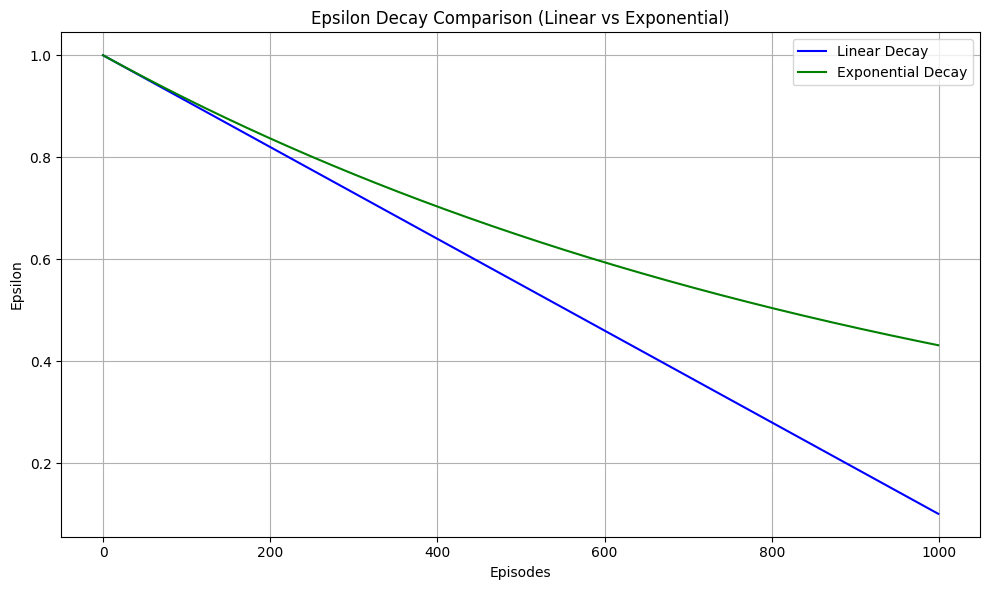

In [10]:
import matplotlib.pyplot as plt

# Define the linear epsilon function
def linear_epsilon(steps_done):
    return max(EPS_END, EPS_START - (EPS_START - EPS_END) * (steps_done / EPS_DECAY))

# Define the corrected exponential epsilon function
def exponential_epsilon(steps_done):
    return EPS_END + (EPS_START - EPS_END) * np.exp(-steps_done / EPS_DECAY)

# Recalculate epsilon values using the defined functions
steps_done = np.arange(NUM_EPISODES)

linear_epsilons = [linear_epsilon(step) for step in steps_done]
exp_epsilons = [exponential_epsilon(step) for step in steps_done]

# Plotting both linear and exponential decay
plt.figure(figsize=(10, 6))
plt.plot(steps_done, linear_epsilons, label='Linear Decay', color='blue')
plt.plot(steps_done, exp_epsilons, label='Exponential Decay', color='green')
plt.title('Epsilon Decay Comparison (Linear vs Exponential)')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Initialize

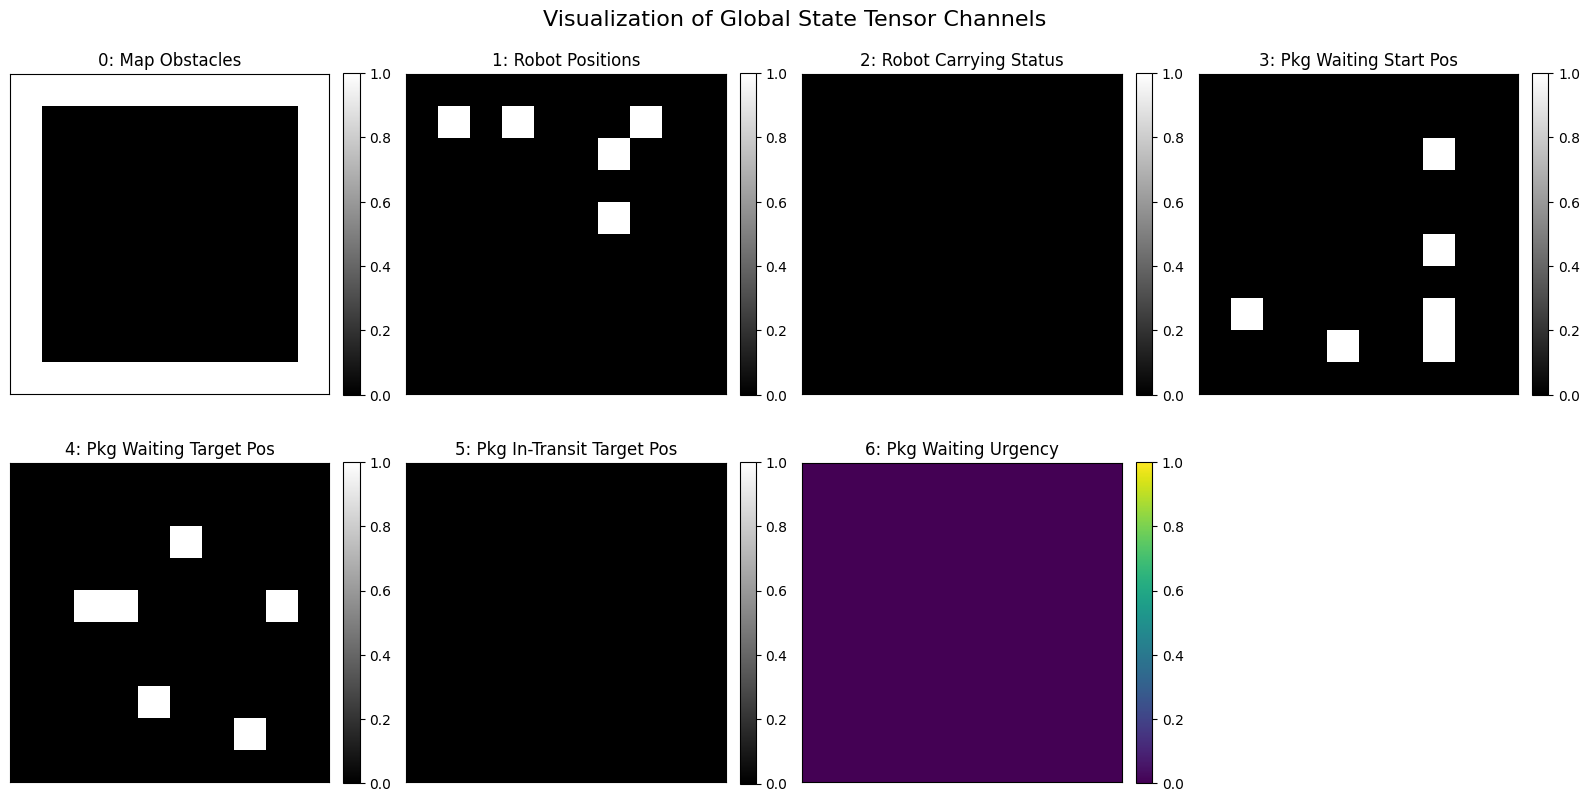

In [11]:
try:
    env = Environment(map_file=MAP_FILE,
                  n_robots=NUM_AGENTS, 
                  n_packages=N_PACKAGES,
                  move_cost=MOVE_COST,
                  delivery_reward=DELIVERY_REWARD,
                  delay_reward=DELAY_REWARD,
                  seed=SEED,
                  max_time_steps=MAX_TIME_STEPS)
except:
    env = Environment(map_file=f"marl_delivery/{MAP_FILE}",
                  n_robots=NUM_AGENTS, 
                  n_packages=N_PACKAGES,
                  move_cost=MOVE_COST,
                  delivery_reward=DELIVERY_REWARD,
                  delay_reward=DELAY_REWARD,
                  seed=SEED,
                  max_time_steps=MAX_TIME_STEPS)
env.reset()

state_dict_sample = env.reset()

# Xây dựng persistent_packages từ state_dict['packages'] (chỉ làm điều này một lần khi gói hàng xuất hiện)
# Hoặc bạn có cơ chế riêng để quản lý persistent_packages
persistent_packages_sample = {}
if state_dict_sample['time_step'] == 0 and 'packages' in state_dict_sample:
    for pkg_tuple in state_dict_sample['packages']:
        pkg_id, sr_1, sc_1, tr_1, tc_1, st, dl = pkg_tuple
        persistent_packages_sample[pkg_id] = {
            'id': pkg_id,
            'start_pos': (sr_1 - 1, sc_1 - 1), # 0-indexed
            'target_pos': (tr_1 - 1, tc_1 - 1), # 0-indexed
            'start_time': st,
            'deadline': dl,
            'status': 'waiting' # Trạng thái ban đầu
        }

# Kiểm tra xem có robot nào đang mang gói hàng không để cập nhật status trong persistent_packages
# (Logic này thường nằm trong vòng lặp chính của môi trường/agent)
for r_data in state_dict_sample['robots']:
    carried_id = r_data[2]
    if carried_id != 0 and carried_id in persistent_packages_sample:
        persistent_packages_sample[carried_id]['status'] = 'in_transit'


desired_shape = (7, 10, 10) # (channels, height, width)
max_t = 1000

global_state_tensor = convert_state(
    state_dict_sample,
    persistent_packages_sample, # Sử dụng persistent_packages đã được xây dựng
    desired_shape,
)

# Tên các kênh để hiển thị (dựa trên logic của hàm convert_state)
channel_names = [
    "0: Map Obstacles",
    "1: Robot Positions",
    "2: Robot Carrying Status",
    "3: Pkg Waiting Start Pos",
    "4: Pkg Waiting Target Pos",
    "5: Pkg In-Transit Target Pos",
    "6: Pkg Waiting Urgency",
]

num_channels_to_plot = global_state_tensor.shape[0]

# Tính toán số hàng và cột cho subplot
# Ví dụ: cho 8 kênh, có thể dùng 2 hàng x 4 cột hoặc 3 hàng x 3 cột
n_rows_plot = (num_channels_to_plot + 3) // 4 if num_channels_to_plot > 4 else 1 # Tối đa 4 cột
if num_channels_to_plot <= 4: n_rows_plot = 1
elif num_channels_to_plot <= 8: n_rows_plot = 2
else: n_rows_plot = (num_channels_to_plot + 2) // 3 # Cho nhiều hơn 8 kênh, dùng 3 cột

n_cols_plot = min(num_channels_to_plot, 4 if num_channels_to_plot > 4 and num_channels_to_plot <=8 else 3)
if num_channels_to_plot <= 4: n_cols_plot = num_channels_to_plot


fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(n_cols_plot * 4, n_rows_plot * 4))
axes = axes.flatten() # Làm phẳng mảng axes để dễ dàng lặp qua

for i in range(num_channels_to_plot):
    ax = axes[i]
    # Sử dụng vmin, vmax để chuẩn hóa thang màu nếu cần, đặc biệt cho kênh urgency
    if i == 6: # Kênh Urgency
        im = ax.imshow(global_state_tensor[i], cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
    else: # Các kênh khác thường là 0 hoặc 1
        im = ax.imshow(global_state_tensor[i], cmap='gray', interpolation='nearest', vmin=0, vmax=1)

    ax.set_title(channel_names[i] if i < len(channel_names) else f"Channel {i}")
    ax.set_xticks([])
    ax.set_yticks([])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Ẩn các subplot không sử dụng nếu có
for j in range(num_channels_to_plot, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Visualization of Global State Tensor Channels", fontsize=16, y=1.02 if n_rows_plot > 1 else 1.05)
plt.show()


In [12]:
def reward_shaping(
    prev_env_state,
    current_env_state,
    actions_taken,
    persistent_packages_before_action,
    num_agents
):
    """
    Compute shaped rewards for each agent using both base and A*-potential-based shaping.
    """
    # --- Constants ---
    SHAPING_SUCCESSFUL_PICKUP_BONUS = 10
    SHAPING_SUCCESSFUL_DELIVERY_BONUS = 100
    SHAPING_LATE_DELIVERY_PENALTY = -50
    SHAPING_WASTED_PICKUP_PENALTY = -0.01
    SHAPING_WASTED_DROP_PENALTY = 0
    SHAPING_STAY_PENALTY = -0.01
    MOVE_COST = -0.01


    individual_rewards = [MOVE_COST] * num_agents

    current_time_from_env = current_env_state['time_step']
    if isinstance(current_time_from_env, np.ndarray):
        current_time_from_env = current_time_from_env[0]

    time_at_prev_state = prev_env_state.get('time_step', current_time_from_env - 1)
    if isinstance(time_at_prev_state, np.ndarray):
        time_at_prev_state = time_at_prev_state[0]

    map_grid = np.array(current_env_state["map"])

    for i in range(num_agents):
        agent_action = actions_taken[i]
        package_op = int(agent_action[1])  # 0: None, 1: Pick, 2: Drop

        prev_robot_info = prev_env_state['robots'][i]
        current_robot_info = current_env_state['robots'][i]

        robot_prev_pos_0idx = (prev_robot_info[0] - 1, prev_robot_info[1] - 1)
        robot_current_pos_0idx = (current_robot_info[0] - 1, current_robot_info[1] - 1)

        # Penalty for staying in place if there are waiting packages
        waiting_packages_exist = any(
            pkg['status'] == 'waiting' and pkg['start_time'] <= time_at_prev_state
            for pkg in persistent_packages_before_action.values()
        )
        if robot_prev_pos_0idx == robot_current_pos_0idx and waiting_packages_exist:
            individual_rewards[i] += SHAPING_STAY_PENALTY
        elif robot_prev_pos_0idx == robot_current_pos_0idx and not waiting_packages_exist:
            individual_rewards[i] -= MOVE_COST  # cancel out move cost if no work to do

        if i >= len(prev_env_state['robots']) or i >= len(current_env_state['robots']):
            continue

        prev_carrying_id = prev_robot_info[2]
        current_carrying_id = current_robot_info[2]


        # --- Base Reward Shaping ---
        # 1. Shaping for PICKUP attempts
        if package_op == 1:
            if prev_carrying_id == 0 and current_carrying_id != 0:
                # Successfully picked up a package
                individual_rewards[i] += SHAPING_SUCCESSFUL_PICKUP_BONUS
            elif prev_carrying_id != 0:
                # Tried to pick up while already carrying
                individual_rewards[i] += SHAPING_WASTED_PICKUP_PENALTY
            elif prev_carrying_id == 0 and current_carrying_id == 0:
                # Attempted pickup but failed (still not carrying).
                package_was_available_and_waiting = False
                for pkg_id, pkg_data in persistent_packages_before_action.items():
                    if pkg_data['status'] == 'waiting' and \
                       pkg_data['start_pos'] == robot_prev_pos_0idx and \
                       pkg_data['start_time'] <= time_at_prev_state:
                        package_was_available_and_waiting = True
                        break
                if not package_was_available_and_waiting:
                    individual_rewards[i] += SHAPING_WASTED_PICKUP_PENALTY

        # 2. Shaping for DROP attempts
        elif package_op == 2:
            if prev_carrying_id != 0 and current_carrying_id == 0:
                dropped_pkg_id = prev_carrying_id
                if dropped_pkg_id in persistent_packages_before_action:
                    pkg_info = persistent_packages_before_action[dropped_pkg_id]
                    pkg_target_pos_0idx = pkg_info['target_pos']
                    pkg_deadline = pkg_info['deadline']
                    if robot_current_pos_0idx == pkg_target_pos_0idx:
                        individual_rewards[i] += SHAPING_SUCCESSFUL_DELIVERY_BONUS
                        if current_time_from_env > pkg_deadline:
                            individual_rewards[i] += SHAPING_LATE_DELIVERY_PENALTY
                # else: dropped a package not in persistent_packages_before_action (should not happen)
            elif prev_carrying_id == 0:
                # Tried to drop when not carrying anything
                individual_rewards[i] += SHAPING_WASTED_DROP_PENALTY

    return individual_rewards


In [13]:
class QMixTrainer:
    def __init__(self, env, lr=LR, weight_decay=WEIGHT_DECAY, 
                 gamma=GAMMA, tau=TAU, 
                 gradient_clipping=GRADIENT_CLIPPING,
                 rnn_hidden_dim=RNN_HIDDEN_DIM, # Added rnn_hidden_dim
                use_data_parallel=True):
        self.env = env
        self.OBS_DIM = (6, env.n_rows, env.n_cols ) 
        self.STATE_DIM = (7, env.n_rows, env.n_cols) 
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.use_data_parallel = use_data_parallel
        self.rnn_hidden_dim = rnn_hidden_dim

        self.lr = lr
        self.weight_decay = weight_decay
        self.gamma = gamma
        self.tau = tau
        self.gradient_clipping = gradient_clipping
        
        # Persistent packages to track the package id and the target position
        self.persistent_packages = {}
        
        # Initialize LabelEncoders for actions
        self.le_move = LabelEncoder()
        self.le_move.fit(['S', 'L', 'R', 'U', 'D']) # Stay, Left, Right, Up, Down
        self.le_pkg_op = LabelEncoder()
        self.le_pkg_op.fit(['0', '1', '2']) # 0: None, 1: Pickup, 2: Drop
        self.NUM_MOVE_ACTIONS = len(self.le_move.classes_) # 5
        self.NUM_PKG_OPS = len(self.le_pkg_op.classes_) # 3
        self.ACTION_DIM = self.NUM_MOVE_ACTIONS * self.NUM_PKG_OPS
        
        # Network
        self.agent_network = AgentNetwork(self.OBS_DIM, self.ACTION_DIM, self.rnn_hidden_dim).to(self.device)
        self.mixing_network = MixingNetwork(self.STATE_DIM, NUM_AGENTS, MIXING_DIM).to(self.device)
        
        # Target networks
        self.target_agent_network = AgentNetwork(self.OBS_DIM, self.ACTION_DIM, self.rnn_hidden_dim).to(self.device)
        self.target_agent_network.load_state_dict(self.agent_network.state_dict())
        self.target_mixing_network = MixingNetwork(self.STATE_DIM, NUM_AGENTS, MIXING_DIM).to(self.device)
        self.target_mixing_network.load_state_dict(self.mixing_network.state_dict())

        # Parallelization
        self.agent_network = nn.DataParallel(self.agent_network)
        self.mixing_network = nn.DataParallel(self.mixing_network)
        self.target_agent_network = nn.DataParallel(self.target_agent_network)
        self.target_mixing_network = nn.DataParallel(self.target_mixing_network)

        if self.use_data_parallel:
            self.target_agent_network.module.load_state_dict(self.agent_network.module.state_dict())
            self.target_mixing_network.module.load_state_dict(self.mixing_network.module.state_dict())
        else:
            self.target_agent_network.load_state_dict(self.agent_network.state_dict())
            self.target_mixing_network.load_state_dict(self.mixing_network.state_dict())

        if self.use_data_parallel:
            self.agent_optimizer = optim.RMSprop(self.agent_network.module.parameters(), lr=self.lr)
            self.mixing_optimizer = optim.RMSprop(self.mixing_network.module.parameters(), lr=self.lr)
        else:
            self.agent_optimizer = optim.RMSprop(self.agent_network.parameters(), lr=self.lr)
            self.mixing_optimizer = optim.RMSprop(self.mixing_network.parameters(), lr=self.lr)

        self.buffer = ReplayBuffer(capacity=MAX_REPLAY_BUFFER_SIZE, 
                                   num_agents=NUM_AGENTS, 
                                   obs_shape=self.OBS_DIM, 
                                   state_shape=self.STATE_DIM, 
                                   device=self.device)

        self.update_targets(1.0)  # Hard update at start

        
    def _update_persistent_packages(self, current_env_state): 
        """
        Updates self.persistent_packages based on the current environment state.
        - current_env_state: The state dictionary from env.step() or env.reset().
        """
        # 1. Add newly appeared packages to persistent_packages if not already tracked
        if 'packages' in current_env_state and current_env_state['packages'] is not None:
            for pkg_tuple in current_env_state['packages']:
                pkg_id = pkg_tuple[0]
                if pkg_id not in self.persistent_packages:
                    self.persistent_packages[pkg_id] = {
                        'id': pkg_id,
                        'start_pos': (pkg_tuple[1] - 1, pkg_tuple[2] - 1),
                        'target_pos': (pkg_tuple[3] - 1, pkg_tuple[4] - 1),
                        'start_time': pkg_tuple[5],
                        'deadline': pkg_tuple[6],
                        'status': 'waiting'
                    }

        # 2. Get current robot carrying info
        current_carried_pkg_ids_set = set()
        if 'robots' in current_env_state and current_env_state['robots'] is not None:
            for r_idx, r_data in enumerate(current_env_state['robots']):
                carried_id = r_data[2] # (pos_x+1, pos_y+1, carrying_package_id)
                if carried_id != 0:
                    current_carried_pkg_ids_set.add(carried_id)

        packages_to_remove_definitively = []

        # 3. Update package status
        for pkg_id, pkg_data in list(self.persistent_packages.items()):
            original_status_in_tracker = pkg_data['status']

            if pkg_id in current_carried_pkg_ids_set:
                # If currently being carried by any robot in current_env_state, set to 'in_transit'
                self.persistent_packages[pkg_id]['status'] = 'in_transit'
            else:
                # Package is NOT being carried in current_env_state
                if original_status_in_tracker == 'in_transit':
                    # This package WAS 'in_transit' (according to our tracker)
                    # and is now NOT carried in current_env_state.
                    # Given the env.py logic, this means it MUST have been delivered correctly.
                    packages_to_remove_definitively.append(pkg_id)
                # If original_status_in_tracker was 'waiting' and it's still not carried,
                # its status remains 'waiting'. No change needed to start_pos or status here.
                pass

        # 4. Remove packages that were successfully delivered
        for pkg_id_to_remove in packages_to_remove_definitively:
            if pkg_id_to_remove in self.persistent_packages:
                del self.persistent_packages[pkg_id_to_remove]


    def update_targets(self, tau=None):
        if tau is None:
            tau = self.tau
        # Soft update
        agent_params_src = self.agent_network.module.parameters() if self.use_data_parallel else self.agent_network.parameters()
        agent_params_tgt = self.target_agent_network.module.parameters() if self.use_data_parallel else self.target_agent_network.parameters()
        mixer_params_src = self.mixing_network.module.parameters() if self.use_data_parallel else self.mixing_network.parameters()
        mixer_params_tgt = self.target_mixing_network.module.parameters() if self.use_data_parallel else self.target_mixing_network.parameters()

        for target_param, param in zip(agent_params_tgt, agent_params_src):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

        for target_param, param in zip(mixer_params_tgt, mixer_params_src):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    def save_models(self, path_prefix="qmix"):
        # Ensure the directory exists
        dir_name = os.path.dirname(path_prefix)
        if dir_name and not os.path.exists(dir_name):
            os.makedirs(dir_name)

        agent_state_dict = self.agent_network.module.state_dict() if self.use_data_parallel else self.agent_network.state_dict()
        mixer_state_dict = self.mixing_network.module.state_dict() if self.use_data_parallel else self.mixing_network.state_dict()

        torch.save(agent_state_dict, f"{path_prefix}_agent.pt")
        torch.save(mixer_state_dict, f"{path_prefix}_mixer.pt")
        print(f"Models saved with prefix {path_prefix}")
        
    def load_models(self, path_prefix="qmix"):
        agent_path = f"{path_prefix}_agent.pt"
        mixer_path = f"{path_prefix}_mixer.pt"

        # Temporarily create models with default rnn_hidden_dim if loading older models
        # or ensure saved models are compatible with current rnn_hidden_dim.
        # For simplicity, we assume new models will be saved with rnn_hidden_dim.
        # If loading models saved *before* RNN was added, this will error.
        # A more robust solution would involve checking model state_dict keys.

        if self.use_data_parallel:
            self.agent_network.module.load_state_dict(torch.load(agent_path, map_location=self.device))
            self.mixing_network.module.load_state_dict(torch.load(mixer_path, map_location=self.device))
        else:
            self.agent_network.load_state_dict(torch.load(agent_path, map_location=self.device))
            self.mixing_network.load_state_dict(torch.load(mixer_path, map_location=self.device))
        
        # Update target networks after loading
        if self.use_data_parallel:
            self.target_agent_network.module.load_state_dict(self.agent_network.module.state_dict())
            self.target_mixing_network.module.load_state_dict(self.mixing_network.module.state_dict())
        else:
            self.target_agent_network.load_state_dict(self.agent_network.state_dict())
            self.target_mixing_network.load_state_dict(self.mixing_network.state_dict())
            
        print(f"Models loaded from prefix {path_prefix}")
        # The old self.update_targets(tau=1.0) is implicitly handled by loading state_dict directly to targets
        # or by re-assigning target_agent_network after loading main agent_network.
        # Let's ensure target networks are correctly updated:
        self.target_agent_network.load_state_dict(self.agent_network.state_dict())
        self.target_mixing_network.load_state_dict(self.mixing_network.state_dict())
    
    def select_action(self, obs_numpy, agent_hidden_state, eps):
        # obs_numpy: numpy array (C, H, W)
        # agent_hidden_state: tensor (1, 1, rnn_hidden_dim)
        obs_tensor = torch.from_numpy(obs_numpy).float().to(self.device)
        # obs_tensor is (C,H,W), AgentNetwork.forward will unsqueeze to (1,C,H,W)
        
        if np.random.rand() < eps:
            action = np.random.randint(0, self.ACTION_DIM)
            # For consistency, if network is called, hidden state should be updated.
            # However, for random action, we can just pass back the same hidden state.
            # Or, to be more rigorous, pass it through the network anyway if you want
            # the hidden state to evolve even on random actions.
            # For simplicity, let's assume random action doesn't require network pass for hidden state update.
            # If network pass is desired:
            # with torch.no_grad():
            #    _, next_hidden_state = self.agent_network(obs_tensor, agent_hidden_state)
            next_hidden_state = agent_hidden_state # Keep hidden state same if action is random
        else:
            with torch.no_grad():
                # obs_tensor is (C,H,W). AgentNetwork.forward handles unsqueezing.
                # agent_hidden_state is (1, 1, rnn_hidden_dim)
                q_values, next_hidden_state = self.agent_network(obs_tensor, agent_hidden_state)
                # q_values will be (1, action_dim)
                action = torch.argmax(q_values.squeeze(), dim=0).item() # Squeeze to (action_dim,)
        return action, next_hidden_state.detach() # Detach to prevent gradients flowing back during rollout
    
    def train_step(self, batch_size):
        if not self.buffer.can_sample(batch_size):
            return None

        batch_states, batch_next_states, batch_obs, batch_next_obs\
        , batch_actions, batch_individual_rewards, batch_dones = \
        self.buffer.sample(batch_size)

        # batch_obs: (B, N, C, H, W)
        # batch_actions: (B, N)
        # batch_individual_rewards: (B, N)
        # batch_next_obs: (B, N, C, H, W)
        # batch_states: (B, C, H, W)
        # batch_next_states: (B, C, H, W)
        # batch_dones: (B, 1)

        B, N_agents, C, H, W = batch_obs.shape # N_agents is NUM_AGENTS
        
        # Use per-agent rewards (already shape [B, N_agents])
        reward_tot = batch_individual_rewards  # shape: (B, N_agents)
        dones = batch_dones.squeeze()          # shape: (B,)

        # Initialize hidden states for the batch (for RNN)
        # Shape: (num_layers * num_directions, batch_size, rnn_hidden_dim) -> (1, B, rnn_hidden_dim)
        initial_hidden_batch = torch.zeros(1, B, self.rnn_hidden_dim, device=self.device)

        # Compute individual Q-values for each agent in current observation
        current_q_s_list = []
        for i in range(N_agents):
            # batch_obs[:, i] is (B, C, H, W)
            q_values_agent_i, _ = self.agent_network(batch_obs[:, i], initial_hidden_batch) # Discard next_hidden
            current_q_s_list.append(q_values_agent_i)
        individual_q_values = torch.stack(current_q_s_list, dim=1)  # [B, N_agents, action_dim]
        
        # Compute Q-values of action that agent has taken
        chosen_q_values = torch.gather(individual_q_values, 2, batch_actions.unsqueeze(-1)).squeeze(-1) # [B, N_agents]

        # Compute Q_tot for the current state
        q_tot = self.mixing_network(chosen_q_values, batch_states)  # [B]
        
        # Compute target Q-values
        with torch.no_grad():
            # Compute individual Q-values for next observation
            next_q_s_list = []
            for i in range(N_agents):
                # batch_next_obs[:, i] is (B, C, H, W)
                q_values_next_agent_i, _ = self.target_agent_network(batch_next_obs[:, i], initial_hidden_batch) # Discard next_hidden
                next_q_s_list.append(q_values_next_agent_i)
            next_individual_q_values = torch.stack(next_q_s_list, dim=1)  # [B, N_agents, action_dim]
            
            # Select best action for next state (Double Q-learning style for target Q selection if desired, but QMIX uses max over target Qs)
            # For standard QMIX, we use target network for both action selection and Q-value estimation for the next state.
            target_q_values = next_individual_q_values.max(dim=-1)[0]  # [B, N_agents]

            # Compute Q_tot for next state using target mixing network
            next_q_tot = self.target_mixing_network(target_q_values, batch_next_states)  # [B]

        # Compute targets
        # Sum per-agent rewards to get the global reward for each sample
        reward_sum = reward_tot.sum(dim=1)  # (B,)
        target_q_tot = reward_sum + self.gamma * (1 - dones) * next_q_tot  # (BATCH_SIZE, )
                
        # Loss
        loss = F.mse_loss(q_tot, target_q_tot.detach())

        # Optimize
        self.agent_optimizer.zero_grad()
        self.mixing_optimizer.zero_grad()
        loss.backward()
        agent_params_to_clip = self.agent_network.module.parameters() if self.use_data_parallel else self.agent_network.parameters()
        mixer_params_to_clip = self.mixing_network.module.parameters() if self.use_data_parallel else self.mixing_network.parameters()
        torch.nn.utils.clip_grad_norm_(agent_params_to_clip, self.gradient_clipping)
        torch.nn.utils.clip_grad_norm_(mixer_params_to_clip, self.gradient_clipping)
        self.agent_optimizer.step()
        self.mixing_optimizer.step()

        # Soft update target networks
        self.update_targets(self.tau)

        return loss.item()


    def run_episode(self, eps):
        current_state_dict = self.env.reset()
        self.persistent_packages = {}
        self._update_persistent_packages(current_state_dict)
        
        # Initialize hidden states for each agent for the RNN
        # Shape for each agent: (num_layers * num_directions, 1, rnn_hidden_dim) -> (1, 1, rnn_hidden_dim)
        # N=1 because we process one observation at a time for this agent.
        agent_hidden_states = [torch.zeros(1, 1, self.rnn_hidden_dim, device=self.device) for _ in range(NUM_AGENTS)]
        
        done = False
        episode_reward = 0
        episode_loss = 0
        step_count = 0

        while not done:
            # self.env.render_pygame()
            # Build per-agent observations
            actions = []
            observations_numpy = [] # Store numpy observations for buffer
            env_actions = []
            
            current_agent_hidden_states_for_step = [] # To store hidden states passed to select_action

            for i in range(NUM_AGENTS):
                obs_numpy = convert_observation(current_state_dict, self.persistent_packages, current_robot_idx=i)
                observations_numpy.append(obs_numpy)
                
                current_agent_hidden_states_for_step.append(agent_hidden_states[i]) # Store current hidden state
                
                # Pass numpy obs and current hidden state
                action, next_hidden_state = self.select_action(obs_numpy, agent_hidden_states[i], eps)
                actions.append(action)
                agent_hidden_states[i] = next_hidden_state # Update hidden state for the next step of this agent
            
            # next_observations_numpy will be populated after env.step()
            prev_state_dict = current_state_dict # Keep a reference before it's updated by env.step()
            prev_state_numpy = convert_state(prev_state_dict, 
                                                        self.persistent_packages,
                                                       self.STATE_DIM)
            
            # Take actions and get next state
            for int_act in actions:
                move_idx = int_act % self.NUM_MOVE_ACTIONS
                pkg_op_idx = int_act // self.NUM_MOVE_ACTIONS

                # Ensure pkg_op_idx is within bounds
                if pkg_op_idx >= self.NUM_PKG_OPS:
                    print(f"Warning: Decoded pkg_op_idx {pkg_op_idx} is out of bounds for action {int_act}. Max is {self.NUM_PKG_OPS-1}. Defaulting to op index 0.")
                    pkg_op_idx = 0 # Default to the first package operation (e.g., 'None')
                
                move_str = self.le_move.inverse_transform([move_idx])[0]
                pkg_op_str = self.le_pkg_op.inverse_transform([pkg_op_idx])[0]
                env_actions.append((move_str, pkg_op_str))
                                            
            current_state_dict, global_reward, done, _= self.env.step(env_actions)
            self._update_persistent_packages(current_state_dict)
            individual_rewards = reward_shaping(
                    prev_state_dict,
                    current_state_dict,
                    env_actions,
                    self.persistent_packages,
                    NUM_AGENTS
                )
            current_state_numpy = convert_state(current_state_dict, 
                                                        self.persistent_packages,
                                                       self.STATE_DIM)
            
            # Build per-agent next observations (numpy)
            next_observations_numpy = []
            for i in range(NUM_AGENTS):
                next_obs_numpy = convert_observation(current_state_dict, self.persistent_packages, current_robot_idx=i)
                next_observations_numpy.append(next_obs_numpy)

            # Store in buffer (using numpy arrays for observations)
            self.buffer.add(
                    obs=np.array(observations_numpy), # List of (C,H,W) -> (N_agents, C,H,W)
                    next_obs=np.array(next_observations_numpy), # List of (C,H,W) -> (N_agents, C,H,W)
                    state=prev_state_numpy, # Name was prev_state, changed to prev_state_numpy for clarity
                    next_state=current_state_numpy,
                    actions=np.array(actions), # List of ints -> (N_agents,)
                    individual_rewards=np.array(individual_rewards),
                    done=done
                )

            episode_reward += global_reward
            step_count += 1

            # Training step
            loss = self.train_step(BATCH_SIZE)
            if loss is not None:
                episode_loss += loss


        return episode_reward, episode_loss / max(1, step_count)

In [16]:
import pygame


trainer = QMixTrainer(env=env, use_data_parallel=True, rnn_hidden_dim=RNN_HIDDEN_DIM) # Pass RNN_HIDDEN_DIM

# Lists to store metrics for plotting
episode_rewards_history = []
episode_avg_loss_history = []

training_completed_successfully = False
print("Starting QMIX training...")
print(f"Running for {NUM_EPISODES} episodes.")

try:
    for episode_num in range(1, NUM_EPISODES + 1):
        # The exponential_epsilon function from in[16] expects 'steps_done'
        # Assuming 'steps_done' in that context refers to the number of episodes completed (0-indexed)
        current_epsilon = linear_epsilon(episode_num - 1) 
        
        episode_reward, avg_episode_loss = trainer.run_episode(current_epsilon)
        
        episode_rewards_history.append(episode_reward)
        episode_avg_loss_history.append(avg_episode_loss)
        
        if episode_num % 10 == 0 or episode_num == NUM_EPISODES: # Print every 10 episodes and the last one
            print(f"Episode {episode_num}/{NUM_EPISODES} | Reward: {episode_reward:.2f} | Avg Loss: {avg_episode_loss:.4f} | Epsilon: {current_epsilon:.3f}")

        # Optional: Periodic saving during training
        if episode_num % 50 == 0: # Example: Save every 50 episodes
            print(f"Saving checkpoint at episode {episode_num}...")
            trainer.save_models(path_prefix=f"models/qmix_agent_ep{episode_num}")
            trainer.save_models(path_prefix=f"models/qmix_mixer_ep{episode_num}")
            
    training_completed_successfully = True

except KeyboardInterrupt:
    print("\nTraining interrupted by user (KeyboardInterrupt).")
    print("Saving current model state...")
    trainer.save_models(path_prefix="models/qmix_agent_interrupted")
    trainer.save_models(path_prefix="models/qmix_mixer_interrupted")
    print("Models saved to _interrupted.pt files.")
except Exception as e:
    print(f"\nAn error occurred during training: {e}")
    import traceback
    traceback.print_exc() # Print detailed traceback for the exception
    print("Saving model due to exception...")
    trainer.save_models(path_prefix="models/qmix_agent_exception")
    trainer.save_models(path_prefix="models/qmix_mixer_exception")
    print("Models saved to _exception.pt files.")
finally:
    print("\nTraining loop finished or was interrupted.")
    # pygame.quit()
    
    # Plotting the results
    if episode_rewards_history: # Check if there's any data to plot
        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        plt.plot(episode_rewards_history)
        plt.title('Total Reward per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(episode_avg_loss_history)
        plt.title('Average Loss per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Average Loss')
        plt.grid(True)

        plt.tight_layout()
        plt.show()
    else:
        print("No data recorded for plotting.")

if training_completed_successfully:
    print("\nTraining completed successfully.")
    print("Saving final model...")
    trainer.save_models(path_prefix="models/qmix_agent_final")
    trainer.save_models(path_prefix="models/qmix_mixer_final")
    print("Final models saved.")

pygame 2.6.1 (SDL 2.28.4, Python 3.9.22)
Hello from the pygame community. https://www.pygame.org/contribute.html
Starting QMIX training...
Running for 1000 episodes.

An error occurred during training: Caught ValueError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/data/hpc/mabot/env/ma/lib/python3.9/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/data/hpc/mabot/env/ma/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_3843841/3170665635.py", line 49, in forward
    raise ValueError(f"Mismatch in hidden_state batch size. Expected {N}, got {hidden_state.size(1)}")
ValueError: Mismatch in hidden_state batch size. Expected 32, got 128

Saving model due to exception...
Models saved with prefix models/qmix_agent_exception
Models saved with prefix models/qmix_mixer_exception
Models saved to _exce

Traceback (most recent call last):
  File "/tmp/ipykernel_3843841/4020476100.py", line 20, in <module>
    episode_reward, avg_episode_loss = trainer.run_episode(current_epsilon)
  File "/tmp/ipykernel_3843841/554162900.py", line 381, in run_episode
    loss = self.train_step(BATCH_SIZE)
  File "/tmp/ipykernel_3843841/554162900.py", line 240, in train_step
    q_values_agent_i, _ = self.agent_network(batch_obs[:, i], initial_hidden_batch) # Discard next_hidden
  File "/data/hpc/mabot/env/ma/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/data/hpc/mabot/env/ma/lib/python3.9/site-packages/torch/nn/parallel/data_parallel.py", line 171, in forward
    outputs = self.parallel_apply(replicas, inputs, kwargs)
  File "/data/hpc/mabot/env/ma/lib/python3.9/site-packages/torch/nn/parallel/data_parallel.py", line 181, in parallel_apply
    return parallel_apply(replicas, inputs, kwargs, self.device_ids[:len(replica

: 